# Load MNIST

In [1]:
from kan import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device('cpu')

In [2]:
train_data = torchvision.datasets.MNIST(root="./data/", train=True, download=True, transform=None)
test_data = torchvision.datasets.MNIST(root="./data/", train=False, download=True, transform=None)

def preprocess_data(data):
    images = []
    labels = []
    for img, label in data:
        img = np.array(img)
        img = img.flatten() / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)

dataset = {
    "train_input": torch.from_numpy(train_images).float().to(device),
    "train_label": torch.from_numpy(train_labels).long().to(device),
    "test_input": torch.from_numpy(test_images).float().to(device),
    "test_label": torch.from_numpy(test_labels).long().to(device),
}

# Train Tiny KAN Model

In [3]:
def create_kan():
    return KAN(width=[784,64,64,64,10], grid=4, k=2).to(device)
    
model = create_kan()
print(model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)


In [4]:
def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy

def train_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["train_input"].to('cpu')), dim=1)
        correct = (predictions == dataset["train_label"].to('cpu')).float()
        accuracy = correct.mean()
    return accuracy

# Train the model
results = model.fit(
    dataset,
    opt="LBFGS",
    steps=20,
    batch=512,
    loss_fn=torch.nn.CrossEntropyLoss(),
    metrics=(train_acc, test_acc)
)

| train_loss: 3.36e-01 | test_loss: 1.21e+00 | reg: 9.28e+03 | : 100%|█| 20/20 [05:08<00:00, 15.45s/


saving model version 0.1


In [5]:
torch.save(model.state_dict(), "kan_mnist_t.pth")

checkpoint directory created: ./model
saving model version 0.0


/tmp/ipykernel_135045/189101918.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("kan_mnist_t.pth"))


Test accuracy: 78.07%
total number of parameters: 835704


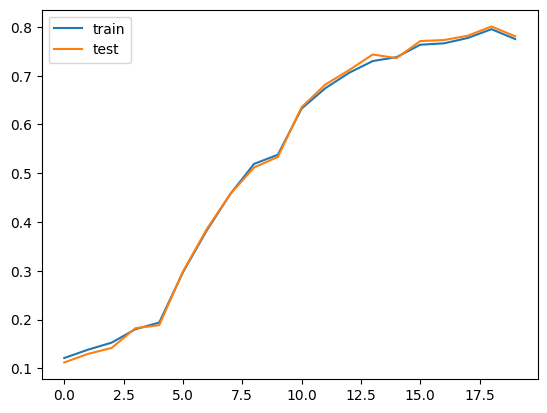

In [6]:
del model
model = create_kan()
model.load_state_dict(torch.load("kan_mnist_t.pth"))

acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_acc"], label="train")
plt.plot(results["test_acc"], label="test")
plt.legend()